In [20]:
from datetime import datetime
from meteostat import Point, Daily
from pythermalcomfort.models import adaptive_ashrae_custom
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import heat_index

plt.style.use('dark_background')

In [21]:
df = pd.read_csv("extracted.csv", parse_dates=['AbsoluteTime'])

In [22]:
df['AbsoluteTime'] = pd.to_datetime(df['AbsoluteTime'], unit='ms')
df['hour'] = df['AbsoluteTime'].dt.hour
df['minute'] = df['AbsoluteTime'].dt.minute
df['second'] = df['AbsoluteTime'].dt.second

In [23]:
df.head()

,EntryId,AbsoluteTime,RelativeTime,NodeId,Temperature,RelativeHumidity,LightSensorOneWaveLength,LightSensorTwoWaveLength,NumberOfOccupants,ActivityOfOccupants,StateOfDoor,StateOfWindow,Room,hour,minute,second
0,1,2016-03-15 08:47:28.545,1,1,20.48,42.332,185.71,492.2,0,0,0,0,A,8,47,28
1,2,2016-03-15 08:47:28.645,1,4,20.73,39.983,214.29,657.8,0,0,0,0,A,8,47,28
2,3,2016-03-15 08:47:28.795,1,3,20.48,38.687,197.14,542.8,0,0,0,0,A,8,47,28
3,4,2016-03-15 08:47:31.038,3,2,20.89,40.712,174.29,552.0,0,0,0,0,A,8,47,31
4,5,2016-03-15 08:47:32.010,4,4,20.73,39.983,211.43,653.2,0,0,0,0,A,8,47,32


In [24]:
df.head()

,EntryId,AbsoluteTime,RelativeTime,NodeId,Temperature,RelativeHumidity,LightSensorOneWaveLength,LightSensorTwoWaveLength,NumberOfOccupants,ActivityOfOccupants,StateOfDoor,StateOfWindow,Room,hour,minute,second
0,1,2016-03-15 08:47:28.545,1,1,20.48,42.332,185.71,492.2,0,0,0,0,A,8,47,28
1,2,2016-03-15 08:47:28.645,1,4,20.73,39.983,214.29,657.8,0,0,0,0,A,8,47,28
2,3,2016-03-15 08:47:28.795,1,3,20.48,38.687,197.14,542.8,0,0,0,0,A,8,47,28
3,4,2016-03-15 08:47:31.038,3,2,20.89,40.712,174.29,552.0,0,0,0,0,A,8,47,31
4,5,2016-03-15 08:47:32.010,4,4,20.73,39.983,211.43,653.2,0,0,0,0,A,8,47,32


In [26]:
mannheim_coordinates = Point(49.488888, 8.469167, 70)
mean_temperatures = {}


def create_average_temperature_column(row):
    start = datetime.strptime(row['AbsoluteTime'].strftime("%d/%m/%Y"), "%d/%m/%Y")
    if start in mean_temperatures:
        return mean_temperatures[start]
    else:
        data = Daily(mannheim_coordinates, start, start)
        data = data.fetch()
        mean_temperatures[start] = data['tavg'][0]
        return data['tavg'][0]


df['MeanTempMannheim'] = df.apply(create_average_temperature_column, axis=1)

In [28]:
df.head()

,EntryId,AbsoluteTime,RelativeTime,NodeId,Temperature,RelativeHumidity,LightSensorOneWaveLength,LightSensorTwoWaveLength,NumberOfOccupants,ActivityOfOccupants,StateOfDoor,StateOfWindow,Room,hour,minute,second,MeanTempMannheim
0,1,2016-03-15 08:47:28.545,1,1,20.48,42.332,185.71,492.2,0,0,0,0,A,8,47,28,4.0
1,2,2016-03-15 08:47:28.645,1,4,20.73,39.983,214.29,657.8,0,0,0,0,A,8,47,28,4.0
2,3,2016-03-15 08:47:28.795,1,3,20.48,38.687,197.14,542.8,0,0,0,0,A,8,47,28,4.0
3,4,2016-03-15 08:47:31.038,3,2,20.89,40.712,174.29,552.0,0,0,0,0,A,8,47,31,4.0
4,5,2016-03-15 08:47:32.010,4,4,20.73,39.983,211.43,653.2,0,0,0,0,A,8,47,32,4.0


In [29]:
def generate_plot(hue="acceptability_80"):
    dfe = df[hue].value_counts(normalize=True)
    print(dfe * 100)
    sns.set(rc={'figure.figsize': (11.7, 8.27)})
    ax = sns.scatterplot(data=df, x="MeanTempMannheim", y="Temperature", hue=hue)
    ax.set(ylabel="Comfort inside temperature", xlabel="Mean outside temperature")


def generate_user_satisfaction(low80=0.3, low90=2.5, high80=0.8, high90=2.5):
    acceptability_80 = []
    acceptability_90 = []
    tmp_cmf = []
    tmp_cmf_80_low = []
    tmp_cmf_80_up = []
    tmp_cmf_90_low = []
    tmp_cmf_90_up = []

    for index in range(0, len(df)):
        mean_temp = df.iloc[index]['MeanTempMannheim']
        temp = df.iloc[index]['Temperature']

        if mean_temp < 10:
            mean = 10
        else:
            mean = mean_temp

        result = adaptive_ashrae_custom(tdb=temp, tr=temp, t_running_mean=mean, v=0.1, low80=low80, low90=low90,
                                        high80=high80, high90=high90)

        acceptability_80.append(result['acceptability_80'])
        acceptability_90.append(result['acceptability_90'])
        tmp_cmf.append(result['tmp_cmf'])
        tmp_cmf_80_low.append(result['tmp_cmf_80_low'])
        tmp_cmf_80_up.append(result['tmp_cmf_80_up'])
        tmp_cmf_90_low.append(result['tmp_cmf_90_low'])
        tmp_cmf_90_up.append(result['tmp_cmf_90_up'])

    df['acceptability_80'] = acceptability_80
    df['acceptability_80'] = df['acceptability_80'].astype(int)
    df['acceptability_90'] = acceptability_90
    df['acceptability_90'] = df['acceptability_90'].astype(int)
    df['tmp_cmf'] = tmp_cmf
    df['tmp_cmf_80_low'] = tmp_cmf_80_low
    df['tmp_cmf_80_up'] = tmp_cmf_80_up
    df['tmp_cmf_90_low'] = tmp_cmf_90_low
    df['tmp_cmf_90_up'] = tmp_cmf_90_up

In [30]:
generate_user_satisfaction(low80=-0.4, low90=-0.2, high80=1.6, high90=1.1)

1    61.171729
0    38.828271
Name: acceptability_80, dtype: float64


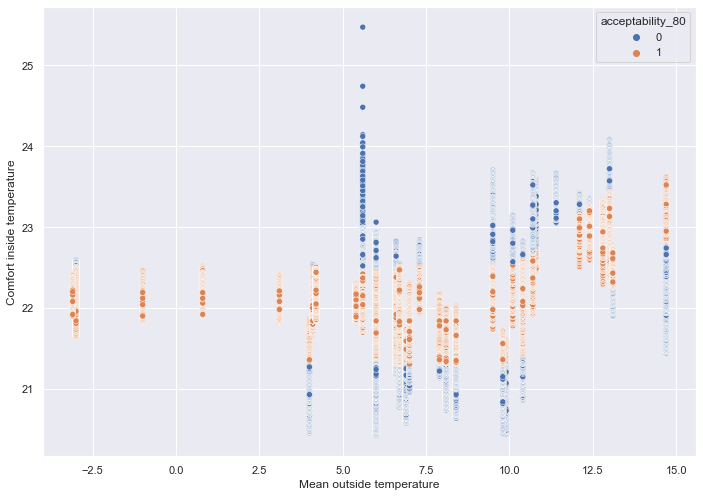

In [32]:
generate_plot("acceptability_80")

0    58.234634
1    41.765366
Name: acceptability_90, dtype: float64


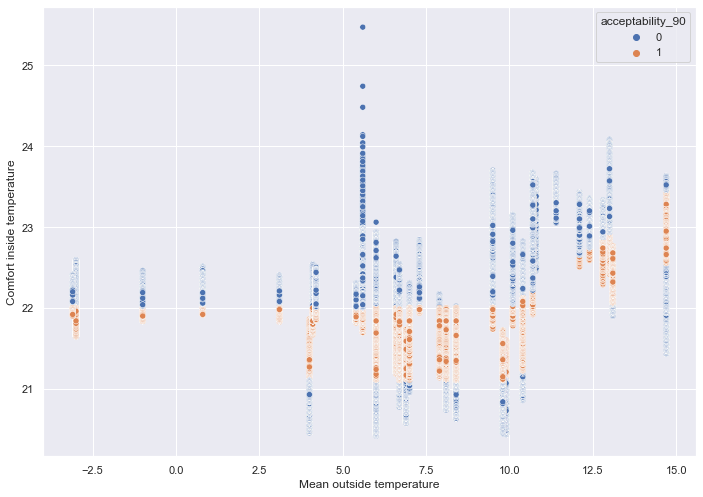

In [33]:
generate_plot("acceptability_90")

In [34]:
heatindex_array = []
for i in range(0, len(df)):
    heatindex = heat_index.calculate.from_celsius(df.iloc[i]['Temperature'], df.iloc[i]['RelativeHumidity'])
    heatindex_array.append(heatindex)

df['HeatIndex'] = heatindex_array

df.head()

,EntryId,AbsoluteTime,RelativeTime,NodeId,Temperature,RelativeHumidity,LightSensorOneWaveLength,LightSensorTwoWaveLength,NumberOfOccupants,ActivityOfOccupants,...,second,MeanTempMannheim,acceptability_80,acceptability_90,tmp_cmf,tmp_cmf_80_low,tmp_cmf_80_up,tmp_cmf_90_low,tmp_cmf_90_up,HeatIndex
0,1,2016-03-15 08:47:28.545,1,1,20.48,42.332,185.71,492.2,0,0,...,28,4.0,0,0,20.9,21.3,22.5,21.1,22.0,20.587526
1,2,2016-03-15 08:47:28.645,1,4,20.73,39.983,214.29,657.8,0,0,...,28,4.0,0,0,20.9,21.3,22.5,21.1,22.0,20.674882
2,3,2016-03-15 08:47:28.795,1,3,20.48,38.687,197.14,542.8,0,0,...,28,4.0,0,0,20.9,21.3,22.5,21.1,22.0,20.504889
3,4,2016-03-15 08:47:31.038,3,2,20.89,40.712,174.29,552.0,0,0,...,31,4.0,0,0,20.9,21.3,22.5,21.1,22.0,20.783859
4,5,2016-03-15 08:47:32.010,4,4,20.73,39.983,211.43,653.2,0,0,...,32,4.0,0,0,20.9,21.3,22.5,21.1,22.0,20.674882


In [35]:
column_names = ["EntryId",
                "NodeId",
                "Room",
                "AbsoluteTime",
                "RelativeTime",
                "Temperature",
                "MeanTempMannheim",
                "HeatIndex",
                "RelativeHumidity",
                "LightSensorOneWaveLength",
                "LightSensorTwoWaveLength",
                "NumberOfOccupants",
                "ActivityOfOccupants",
                "StateOfDoor",
                "StateOfWindow",
                "acceptability_80",
                "acceptability_90",
                "tmp_cmf",
                "tmp_cmf_80_low",
                "tmp_cmf_80_up",
                "tmp_cmf_90_low",
                "tmp_cmf_90_up"]

df = df.reindex(columns=column_names)

In [36]:
df = df.rename(columns={
    "EntryId": "original_entry_id",
    "NodeId": "node_id",
    "Room": "room",
    "AbsoluteTime": "datetime",
    "RelativeTime": "relative_time",
    "Temperature": "temperature",
    "MeanTempMannheim": "mean_temp_day",
    "HeatIndex": "heatindex",
    "RelativeHumidity": "relative_humidity",
    "LightSensorOneWaveLength": "light_sensor_one_wavelength",
    "LightSensorTwoWaveLength": "light_sensor_two_wavelength",
    "NumberOfOccupants": "number_occupants",
    "ActivityOfOccupants": "activity_occupants",
    "StateOfDoor": "door_state",
    "StateOfWindow": "window_state",
    "acceptability_80": "acceptability_80",
    "acceptability_90": "acceptability_90",
    "tmp_cmf": "tmp_cmf",
    "tmp_cmf_80_low": "tmp_cmf_80_low",
    "tmp_cmf_80_up": "tmp_cmf_80_up",
    "tmp_cmf_90_low": "tmp_cmf_90_low",
    "tmp_cmf_90_up": "tmp_cmf_90_up"
})

In [37]:
df.head()

,original_entry_id,node_id,room,datetime,relative_time,temperature,mean_temp_day,heatindex,relative_humidity,light_sensor_one_wavelength,...,activity_occupants,door_state,window_state,acceptability_80,acceptability_90,tmp_cmf,tmp_cmf_80_low,tmp_cmf_80_up,tmp_cmf_90_low,tmp_cmf_90_up
0,1,1,A,2016-03-15 08:47:28.545,1,20.48,4.0,20.587526,42.332,185.71,...,0,0,0,0,0,20.9,21.3,22.5,21.1,22.0
1,2,4,A,2016-03-15 08:47:28.645,1,20.73,4.0,20.674882,39.983,214.29,...,0,0,0,0,0,20.9,21.3,22.5,21.1,22.0
2,3,3,A,2016-03-15 08:47:28.795,1,20.48,4.0,20.504889,38.687,197.14,...,0,0,0,0,0,20.9,21.3,22.5,21.1,22.0
3,4,2,A,2016-03-15 08:47:31.038,3,20.89,4.0,20.783859,40.712,174.29,...,0,0,0,0,0,20.9,21.3,22.5,21.1,22.0
4,5,4,A,2016-03-15 08:47:32.010,4,20.73,4.0,20.674882,39.983,211.43,...,0,0,0,0,0,20.9,21.3,22.5,21.1,22.0


In [38]:
df.to_csv('dataset.csv', index=False)